<br>
# ** 6 Predict the TimeSeries Data**
시계열 데이터 예측

<br><br>
## ** 3 prophet 모듈의 활용**
pip install --no-cache-dir  fbprophet
1. [웹사이트](https://facebook.github.io/prophet/)
1. R 에서 유명한 모듈
1. Value At Risk 유효범위내 주가변동을 예측한다
1. https://facebook.github.io/prophet/docs/quick_start.html#python-api
1. https://github.com/WillKoehrsen/Data-Analysis/blob/master/stocker/stocker.py
1. https://github.com/kumaranvpl/predict_stock_price/blob/master/predict_stock.py
1. https://towardsdatascience.com/stock-prediction-in-python-b66555171a2

<br>
### ** 01 prophet 모델 만들기**
'ds', 'y' 로 컬럼명을 수정해야 입력 포맷이 완성된다

In [1]:
from pandas_datareader import get_data_yahoo
stock = get_data_yahoo('032830.KS', '2017-01-01')
stock.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-06-04,104500.0,102500.0,103000.0,103000.0,215713.0,103000.0
2018-06-05,104500.0,103000.0,103000.0,103500.0,187418.0,103500.0
2018-06-07,106000.0,104000.0,104000.0,105000.0,243102.0,105000.0


In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

df         = stock.reset_index()
df         = df.filter(['Date', 'Close'] , axis=1)
df.columns = ['ds', 'y']
df['y']    = np.log(df['y'])

# 예측 모델 만들기
# daily_seasonality = True : 시간별 자료가 제공시 활성화 한다
m = Prophet(yearly_seasonality = True)
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/markbaum/Python/python/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<br>
### ** 02 예측 데이터 생성하기**
num_days : 예측일 입력

/home/markbaum/Python/python/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/home/markbaum/Python/python/lib/python3.6/site-packages/fbprophet/forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale
/home/markbaum/Python/python/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


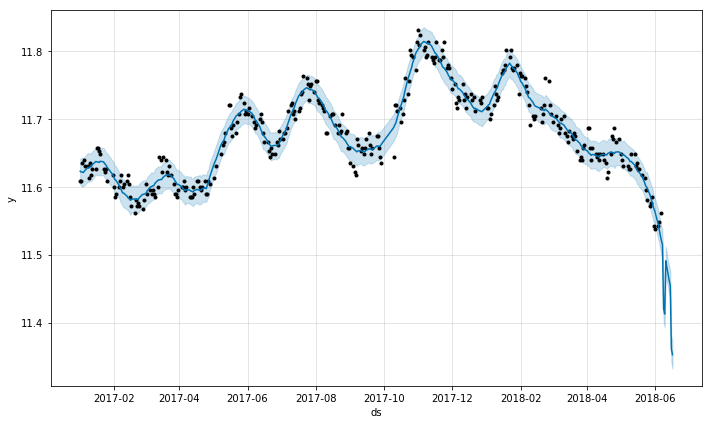

In [3]:
# 주가 예측기간 정의하기
num_days = 10
future   = m.make_future_dataframe(periods = num_days)
forecast = m.predict(future)
plt      = m.plot(forecast)
plt.show()

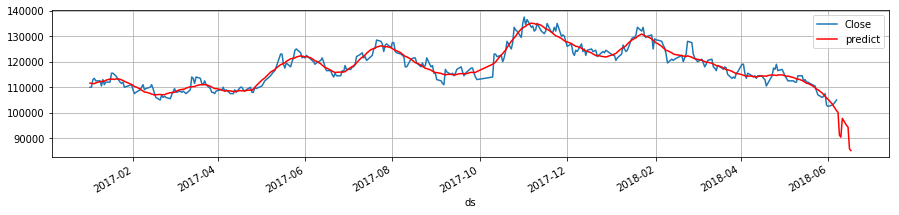

In [4]:
# log 데이터를 실제 주가데이터로 변환
forecast['Close'] = round(np.exp(forecast.yhat), 2)

df_predict = forecast.filter(['ds', 'Close'])
df_predict = df_predict.set_index('ds')

stock.Close.plot(label='Close', figsize=(15,3), legend=True)
df_predict.Close.plot(label='predict', grid=True, color='red', legend=True)

<br>
### ** 03 결과 보고서 시각화**
모델분석 Report 출력하기

/home/markbaum/Python/python/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/home/markbaum/Python/python/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


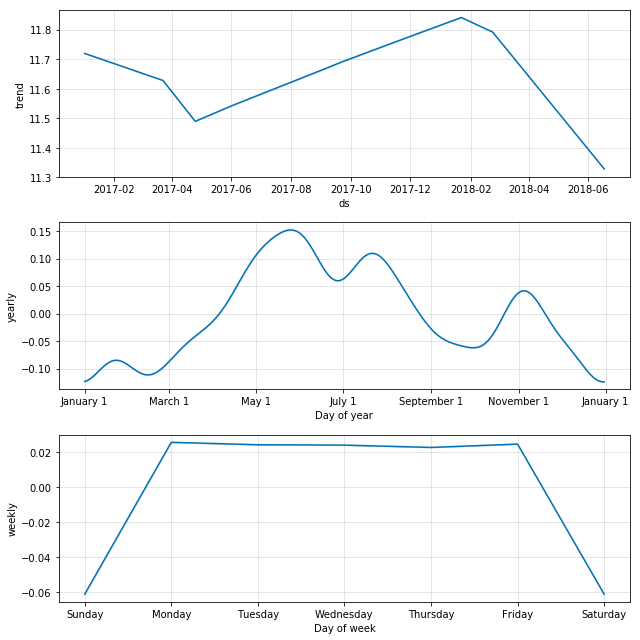

In [5]:
# 모델분석 Report 출력하기
plt = m.plot_components(forecast)
plt.show()

<br><br>
## ** 4 Keras 를 활용한 주가예측**
[Kaggle 주가분석](https://www.kaggle.com/pablocastilla/predict-stock-prices-with-lstm)
1. Python Code : https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/master/StockPricePrediction.py
1. https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html
1. https://www.kaggle.com/pablocastilla/predict-stock-prices-with-lstm
1. https://github.com/etai83/lstm_stock_prediction/blob/master/.ipynb_checkpoints/GOOGLE%20stock%20prediction-checkpoint.ipynb
<br><img src="https://static.wixstatic.com/media/5dad68_6d27591c7f5240618a59cbd15f21258d~mv2.png/v1/fill/w_542,h_191,al_c,lg_1/5dad68_6d27591c7f5240618a59cbd15f21258d~mv2.png" align="left">

<br>
### ** 01 데이터 전처리**
주가의 종가데이터 전처리

In [6]:
# 데이터 불러오기
from pandas_datareader import get_data_google, get_data_yahoo
# stock = get_data_google('NASDAQ:FB', '2017-01-01')
# stock = get_data_google('NASDAQ:TSLA', '2017-01-01')
stock = get_data_yahoo('032830.KS', '2017-01-01')
dataset = stock.reset_index()
del dataset['Volume']
dataset.head(2)

,Date,High,Low,Open,Close,Adj Close
0,2017-01-02,113000.0,109000.0,112000.0,110000.0,108225.804688
1,2017-01-03,111500.0,109000.0,110000.0,110000.0,108225.804688


In [7]:
# 관련 라이브러리 호출
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


In [8]:
np.random.seed(7)                                            # 몬테카를로 시뮬레이션을 위한 난수 Seed값 생성
obs       = np.arange(1, len(dataset) + 1, 1)                # 전체 자료들의 index 숫자 array를 생성 
OHLC_avg  = dataset.mean(axis = 1)                           # OHLC 의 평균값 Series 생성
HLC_avg   = dataset[['High', 'Low', 'Close']].mean(axis = 1) # HLC 의 평균값 Series 생성
close_val = dataset[['Close']]                               # Close 종가 Series 생성

In [9]:
# 시계열 데이터를 Broadcasting 연산을 위해서 차원변환
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler   = MinMaxScaler(feature_range=(0, 1))  # 0~1 정규화 변환모델 생성
OHLC_avg = scaler.fit_transform(OHLC_avg)      # 주가 데이터 정규화

<br>
### ** 02 Train / Test 데이터 나누기**
1. Train(75%), Test(25%) 데이터 나누기
1. 모델의 일반화, Overfit 딜레마

In [10]:
# 시계열 데이터를 1차원 Array() 로 변환
def new_dataset(dataset, step_size):
    import numpy as np 
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        a = dataset[i : (i + step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [11]:
step_size = 1

# OHLC 데이터를 75% 25% 나누기 (시간 순서를 기준으로 분할)
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC  = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# 분할 데이터를 시계열 numpy array 객체로 변환
# trainX 와 trainY 의 "차분간격"을 설정 ( FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, step_size)
testX, testY   = new_dataset(test_OHLC, step_size)
print("trainX's shape : {} \ntrainY's shape : {}".format(trainX.shape, testX.shape))

trainX's shape : (258, 1) 
trainY's shape : (85, 1)


In [12]:
# 데이터 분석을 위한 1차원 추가
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print("trainX's shape : {} \ntrainY's shape : {}".format(trainX.shape, testX.shape))

trainX's shape : (258, 1, 1) 
trainY's shape : (85, 1, 1)


<br>
### ** 03 LSTM 모델 만들고 예측 데이터 생성**
주가의 종가데이터 전처리

<img src="https://jaydottechdotblog.files.wordpress.com/2016/12/rnn-lstm-cell.png?w=730" align="left">

In [13]:
# LSTM MODEL 정의하기
# 1 layer (32개의 cell)
# 2 layer (16개의 cell)
# 3 layer (Fully connected)
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 3s - loss: 0.0337
Epoch 2/5
 - 2s - loss: 0.0077
Epoch 3/5
 - 2s - loss: 0.0035
Epoch 4/5
 - 2s - loss: 0.0024
Epoch 5/5
 - 2s - loss: 0.0022


In [14]:
# 모델을 기반한 예측 데이터 생성하기 (PREDICTION)
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

# 0~1 정규화한 데이터를 원본으로 되돌리기
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY       = scaler.inverse_transform([trainY])
testPredict  = scaler.inverse_transform(testPredict)
testY        = scaler.inverse_transform([testY])

# RMSE Score (Root-mean-square deviation) 측정하기
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))   # Train 모델 RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test  RMSE: %.2f' % (testScore))     # Test 모델 RMSE

Train RMSE: 1536.49
Test  RMSE: 1716.17


<br>
### ** 04 Visualization**
주가의 종가데이터 LSTM 모델 및 예측결과 시각화

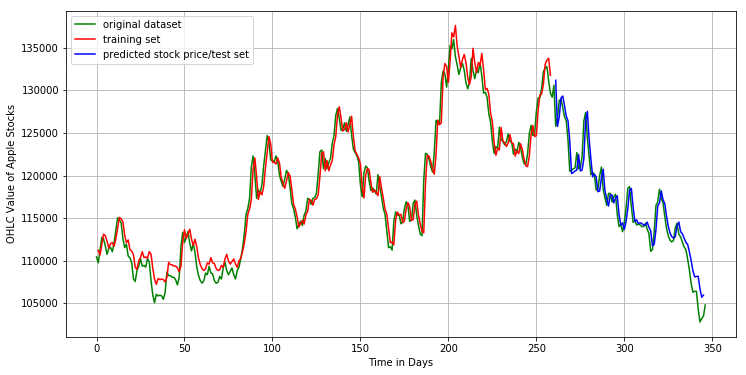

In [15]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot       = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size : len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot       = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(12,6))
plt.plot(OHLC_avg,         'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot,  'b', label = 'predicted stock price/test set')
plt.xlabel('Time in Days');     plt.ylabel('OHLC Value of Apple Stocks')
plt.legend(loc = 'upper left'); plt.grid(); plt.show()

<br>
### ** 05 예측 데이터 생성**
1. 데이터 마지막 값을 통해서 새로운 가격을 예측
1. 1일 이상 예측이 어려운 한계가 존재 
1. 예측값을 검증하고 확인할 Target 자료가 없어서 장기간 기간 예측이 불가능
1. Target 예측치가 실제 결과와 다르면 나비효과로 결과예측도 일정한 패턴이 없어서 효과가 떨어짐  

In [16]:
# PREDICT FUTURE VALUES
last_val        = testPredict[-1:]
last_val_scaled = last_val/last_val
next_val        = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", np.asscalar(last_val))
print ("Next Day Value:", np.asscalar(last_val * next_val))

Last Day Value: 105963.421875
Next Day Value: 111291.75


<br><br>
## ** 추가 학습자료 사이트 **
1. https://www.quantopian.com/
1. https://datascienceschool.net/view-notebook/168e612af62943d2ba6b92b760759be6/

<img src="http://cfile213.uf.daum.net/image/117FEB445008C375278E2A" align="left">

## 마무리
1. 주가 예측의 핵심은 **실적 예측**이다
1. 그리고 지분의 변화 (블록딜, 상속, 연결재무제표와 단독 재무제표의 비교)
1. 수급분석, 이슈(테마)분석, 뉴스분석, 공시분석, 재무제표 분석 등등...
1. 그리고 해외 시장과의 연계성등 따지다 보면 한도끝도 없다
1. 종목에 대한 자신만의 View, 수치화 및 파생변수의 추출 등 끊임없는 노력이 필요하다
1. 그리고 통계적 수학적 지식과, 프로그래밍 언어에 대한 기본 지식은 덤...

## 결론
[Blog](http://blog.daum.net/_blog/BlogTypeView.do?blogid=0DM1r&articleno=3249&_bloghome_menu=recenttext)
1. 자신만의 투자철학을 갖고 꾸준하게 매수, 매도를 한다
1. 내가 아는 내용을 Coding으로 정리하면, 뺴먹지 않고 꾸준하게 반복적으로 자동으로 점검을 한다
1. 1개의 언어라도 제대로 안다면, 다른 Javascript/ Sql/ Linux 에 접근이 쉬워지고 단단해진다
1. 반면 내가 모르는, 남이 만든것 그대로 사용하면
1. AS가 필요하거나, 내용변경이 필요할 때 속수무책이 된다.
1. Less is More 잘 아는 부분 부터 시작하자
1. 내가 아는 내용을 Code로 잘 짜서 정리하고 이를 꾸준하게 수정 보완해 나아간다면 이보다 더 좋은 재태크는 없을것이다
1. 단 꾸준하게 수정 보완을 해 나아가야 한다는 점을 잊지마라 
1. 100% 자동으로 알아서는 없다. 도로에서 운전하는 단순한 일도 Auto Pilot Drive 사망사고가 발생하는 2018년이다
<img src="http://www.businessbooksmakeyourich.com/wp-content/uploads/2011/02/Long-tail1.jpg" align="left">